# Marshall Stability

In [5]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

## 2. Data Import

In [4]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption [%]',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [5]:
dfMS = returnDf('MS')

## 3. Data Exploration
###  3.1 Total Sample

In [6]:
dfMS = eliminateOutliers(dfMS, 'MS of the sample (kN)')

Initial dataframe size: (406, 34)
Final dataframe size: (402, 34)


In [ ]:
dfMS.iloc[:,2:].describe(include = 'all')

I might have a problem with the $\color{red}{\text{Aggregate absorption}}$ because more than 20% of the data is missing. Regarding the $\color{red}{\text{MS}}$, there is a high dispersion ($\sigma$ = 4.56), and the Mean seems normal. According to the Australian standards, the minimum value of the Marshall stability is between two and eigth.

In [ ]:
scatter_matrix(dfMS[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'MS of the sample (kN)']], figsize=(10, 10))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMS.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12);

Interestingly, there is positive correlation in $\color{red}{\text{MS-Apparent specific gravity}}$ and $\color{red}{\text{MS-plastic addition by bitumen content}}$.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMS, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

*   As it happened with the Air Voids, it exists a MS difference among the samples that employed the bitumen 40/50; however, it is important to note that the sample size for this group was not representative enough.

*   Samples with plastic modification tend to have higher MS. The glue effect of the plastic and the stiffness increase of the bitumen might serve as valid explanations.

*   No signigicant difference among the aggregate types and fillers

###  3.2 Modified mixtures

In [ ]:
dfMSModvsUnmod = dfMS [['Modified asphalt Mix?', 'MS of the sample (kN)']]
dfMSModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfMSModified = dfMS[dfMS['Modified asphalt Mix?'] == 'Yes']
dfMSModified.describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MS of the sample (kN)']
scatter_matrix(dfMSModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMSModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MS', fontdict={'fontsize':12}, pad=12)

 $\color{red}{\text{MS-Apparent specific gravity}}$ presents the highest correlation with  $\color{red}{\text{MS}}$; however, it only has 66 observations, so it is not a convincing result. Other parameters such as  $\color{red}{\text{Plastic content}}$, and  $\color{red}{\text{gradation}}$ present an slight effect on the MS.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMSModified, propertyOfInterest = "MS of the sample (kN)", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The mean of the **dry** and **wet** process are not significantly different.

###  3.3 Wet vs. Dry Mixing

In [ ]:
dfMSWetvsDry = dfMSModified [['Mixing Process', 'MS of the sample (kN)']]
dfMSWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfMSModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Marshall Stability summary:**

*   There are missing values mainly in $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{Aggregate type}}$ and $\color{red}{\text{filler used}}$.
*   Four outliers were eliminated. The final total sample included 402 data points ($\mu$ = 14.47, $\sigma$ = 4.6). 
*   $\color{red}{\text{Aggregate absorption}}$ seems to be a critical variable to include, but the percentage of missing values is more than 20%.
*   $\color{red}{\text{Apparent specific gravity}}$ presents the strongest positive correlation with the Marshall stability, but it is not a reliable inference becasue it presents many missing points (318 missing points).
* Although Marshall stability of modified asphalts is relatively higher than not modified, this is not certain because the high variances of both sample groups. $\mu_{modified}$ = 15.12 vs. $\mu_{unmodified}$ = 11.97
*   $\color{red}{\text{Percentage of plastic addition}}$ has a noticeable possitive correlation with MS. (r = 0.39) 
*   MS of dry and wet are really similar -> $\mu_{Dry}$ = 15.05 (200 observations) vs $\mu_{Wet}$ = 15.2 (119 observations)

## 4. Data Pre-processing

In [7]:
dfMS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402 entries, 1 to 406
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              402 non-null    object 
 1   Global ID                               402 non-null    object 
 2   Modified asphalt Mix?                   402 non-null    object 
 3   Agreggate Type                          262 non-null    object 
 4   Aggregate absorption (%)                242 non-null    float64
 5   Apparent specific gravity               84 non-null     float64
 6   0.075                                   325 non-null    float64
 7   0.3                                     372 non-null    float64
 8   0.6                                     344 non-null    float64
 9   2.36                                    355 non-null    float64
 10  4.75                                    372 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration}}$, $\color{red}{\text{Property}}$, $\color{red}{\text{plastic size}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen}}$ content in sample
4.  Change categorical columns to numeric.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [8]:
#Categorical Variables
dfMSCleaned = dfMS.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade', 
                        'Property', 
                        'Units', 
                        'Plastic Size' ], axis = 1)
dfMSCleaned = dfMSCleaned.replace('N/a', 0)
dfMSCleaned = dfMSCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMSCleaned = pd.get_dummies(dfMSCleaned, columns=['New Plastic Type'], drop_first = False)
dfMSCleaned = pd.get_dummies(dfMSCleaned, drop_first = True)
dfMSCleaned = dfMSCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMSCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 1 to 406
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       217 non-null    float64
 1   0.075                                          322 non-null    float64
 2   0.3                                            369 non-null    float64
 3   0.6                                            341 non-null    float64
 4   2.36                                           352 non-null    float64
 5   4.75                                           369 non-null    float64
 6   9.5                                            341 non-null    float64
 7   12.5                                           354 non-null    float64
 8   19                                             369 non-null    float64
 9   Plastic particle size (mm)                     304 non

In [9]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=123), max_iter=50)
n = imputer.fit_transform(dfMSCleaned)
dfMSCleanedImputed = pd.DataFrame(n, columns = list(dfMSCleaned.columns))
dfMSCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMSCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       374 non-null    float64
 1   0.075                                          374 non-null    float64
 2   0.3                                            374 non-null    float64
 3   0.6                                            374 non-null    float64
 4   2.36                                           374 non-null    float64
 5   4.75                                           374 non-null    float64
 6   9.5                                            374 non-null    float64
 7   12.5                                           374 non-null    float64
 8   19                                             374 non-null    float64
 9   Plastic particle size (mm)                     374 non

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [10]:
dfMSCleanedImputed['New Plastic Type_Nylon'] = dfMSCleanedImputed['New Plastic Type_Nylon'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PE'] = dfMSCleanedImputed['New Plastic Type_PE'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PET'] = dfMSCleanedImputed['New Plastic Type_PET'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PP'] = dfMSCleanedImputed['New Plastic Type_PP'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PU'] = dfMSCleanedImputed['New Plastic Type_PU'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_PVC'] = dfMSCleanedImputed['New Plastic Type_PVC'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_Plastic Mix'] = dfMSCleanedImputed['New Plastic Type_Plastic Mix'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed['New Plastic Type_e-waste'] = dfMSCleanedImputed['New Plastic Type_e-waste'] * dfMSCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMSCleanedImputed = dfMSCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [11]:
scaler = MinMaxScaler()
dfMSCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMSCleanedImputed), columns = list(dfMSCleanedImputed.columns))
dfMSCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [12]:
min = dfMSCleanedImputed['MS of the sample (kN)'].min()
max = dfMSCleanedImputed['MS of the sample (kN)'].max()
print('The min value is: '+str(min)+'. The max value is: '+str(max))

The min value is: 1.36784. The max value is: 26.9


In [ ]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModelAdv (grid, estimator = n, advancedAnalysis = False):
    min = dfMSCleanedImputed['MS of the sample (kN)'].min()
    max = dfMSCleanedImputed['MS of the sample (kN)'].max()
    mse = -grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best Test MSE: ' + str(mse))
    print('Std of the Test MSE:' + str(grid.cv_results_['std_test_neg_mean_squared_error'][grid.best_index_]))
    print('Best Test RMSE: ' +str(math.sqrt(mse)))
    print('Best Test scaled RMSE: ' +str((math.sqrt(mse)*(max-min))+min))
    print('Best Test scaled MSE: ' +str(((math.sqrt(mse)*(max-min))+min)**2)) 
    print('Best Test R2: ' + str(grid.cv_results_['mean_test_r2'][grid.best_index_]))
    if (advancedAnalysis):
        bestEstimator = estimator
        bestEstimator.fit(X_train, y_train)
        predictionsTrain = bestEstimator.predict(X_train)
        df = pd.DataFrame({'predictions':predictionsTrain, 'original': y_train})
        df.plot.hist(bins=10, alpha=0.5)
        unScaledDf = (df*(max-min))+min
        print (unScaledDf.describe())

In [13]:
X = dfMSCleanedImputedScaled.loc[:, dfMSCleanedImputedScaled.columns != 'MS of the sample (kN)']
X.columns = X.columns.astype(str)
y = dfMSCleanedImputedScaled.loc[:,'MS of the sample (kN)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

In [15]:
y_train_new = y_train.to_frame()
y_train_new['y_train_unscaled'] = (y_train*(max-min))+min

In [16]:
y_train_new.describe()

,MS of the sample (kN),y_train_unscaled
count,299.000000,299.000000
mean,0.495588,14.021276
std,0.179733,4.588971
min,0.011728,1.667280
25%,0.353580,10.395513
50%,0.491622,13.920000
75%,0.615975,17.095000
max,1.000000,26.900000


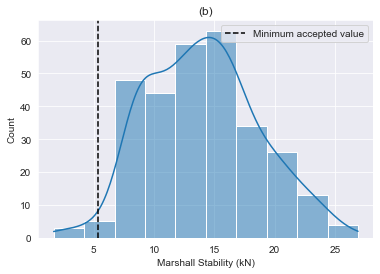

In [17]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
sns.histplot(x=y_train_new["y_train_unscaled"], bins=10, kde=True, ax = ax)
ax.set(xlabel='Marshall Stability (kN)')
ax.axvline(x=5.33, label='Minimum accepted value' , linestyle = '--', color='k')
ax.set_title('(b)')
ax.legend()
plt.show()

### 5.1 Model Evaluation
#### Linear Model

In [ ]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv = cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid) 

#### Lasso Linear Model

In [ ]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge Linear regression model

In [ ]:
param_grid = {'alpha': [7, 8, 10,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Linear Elastic net

In [ ]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Lasso Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1,2, 3, 10, 15, 30],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [2000,3000, 3500]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Ridge polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[20,30,50, 60],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'auto']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Support vector regression

In [ ]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid', 'poly'],
    'degree':[2,3,4],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.2, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Decision Tree regressor

In [ ]:
param_grid = {
    'max_depth':[1,2,3,5,10,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[0.4,1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid)

#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2,4,5,10],
    'min_samples_split': [2],
    'n_estimators': [400]
}
grid = GridSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=10)
grid.fit(X_train, y_train)
printBestModelAdv(grid, RandomForestRegressor(**grid.best_params_), True)

#### XG Boost Regressor

In [20]:
param_grid = {
    'n_estimators': [100,300,500,1000]
}
grid = GridSearchCV(XGBRegressor(random_state=123), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
grid.fit(X_train, y_train)
printBestModelAdv(grid, XGBRegressor(**grid.best_params_), True)

KeyboardInterrupt: 

In [21]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [22]:
X_train2 = X_train.copy()
X_train2.rename(columns={'0.075':'Grad. Sieve size 0.075', '0.3':'Grad. Sieve size 0.3', '0.6':'Grad. Sieve size 0.6', '2.36':'Grad. Sieve size 2.36',                                '4.75':'Grad. Sieve size 4.75','9.5':'Grad. Sieve size 9.5', '12.5':'Grad. Sieve size 12.5', '19':'Grad. Sieve size 19', 
                        'Plastic particle size (mm)':'Plastic size', 'Mixing speed (RPM)':'Mixing speed',
                        'Mixing Time (hours)':'Mixing Time',
                        'Bitumen content in the sample':'Bitumen content', 'New Plastic Type_Nylon':'Plastic Type_Nylon',
                        'New Plastic Type_PE':'Plastic Type_PE', 'New Plastic Type_PET':'Plastic Type_PET', 'New Plastic Type_PP':'Plastic Type_PP',
                         'New Plastic Type_PU':'Plastic Type_PU', 'New Plastic Type_PVC':'Plastic Type_PVC',
                        'New Plastic Type_Plastic Mix':'Plastic Type_Plastic Mix', 'New Plastic Type_e-waste':'Plastic Type_e-waste' ,
                        'Consolidated bitumen penetration grade_50/70':'Bitumen grade_50/70',
                        'Consolidated bitumen penetration grade_70/100':'Bitumen grade_70/100',
       }, inplace=True)

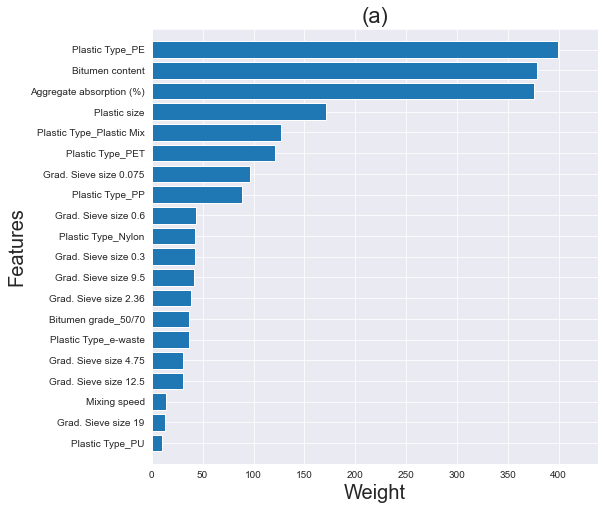

In [25]:
#Graph employed for selecting important features during tunning
XGBoostModel = XGBRegressor(random_state=123)
XGBoostModel.fit(X_train2,y_train)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='weight', show_values=False, title=None, max_num_features = 20)
fig = ax.figure
plt.xlabel('Weight', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('(a)',fontsize= 22)
fig.set_size_inches(8,8)

## 6. Best Model Tunning

In [26]:
X_train.columns = X_train.columns.astype(str)
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

### 6.1. Feature selection

In [27]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 123), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [28]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [29]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste'], 
       'Plastic type')

In [30]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample'], 
       'Plastic type \n Bitument cont.')

In [31]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)'], 
       'Plastic type \n Bitument cont. \n Aggregates abs.')

In [32]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)'], 
       'Plastic type \n Bitument cont. \n Aggregates abs. \n Plastic size')

In [33]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
       'Plastic type \n Bitument cont. \n Aggregates abs. \n Plastic size \n Gradation')

In [34]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100'], 
       'Plastic type \n Bitument cont. \n Aggregates abs. \n Plastic size \n Gradation \n Bitumen type')

In [35]:
addMSE(['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
       'Mixing speed (RPM)', 'Mixing Temperature'], 
       'Plastic type \n Bitument cont. \n Aggregates abs. \n Plastic size \n Gradation \n Bitumen type \n Mixing speed \n Mixing Temp.')

In [36]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
        'All features')

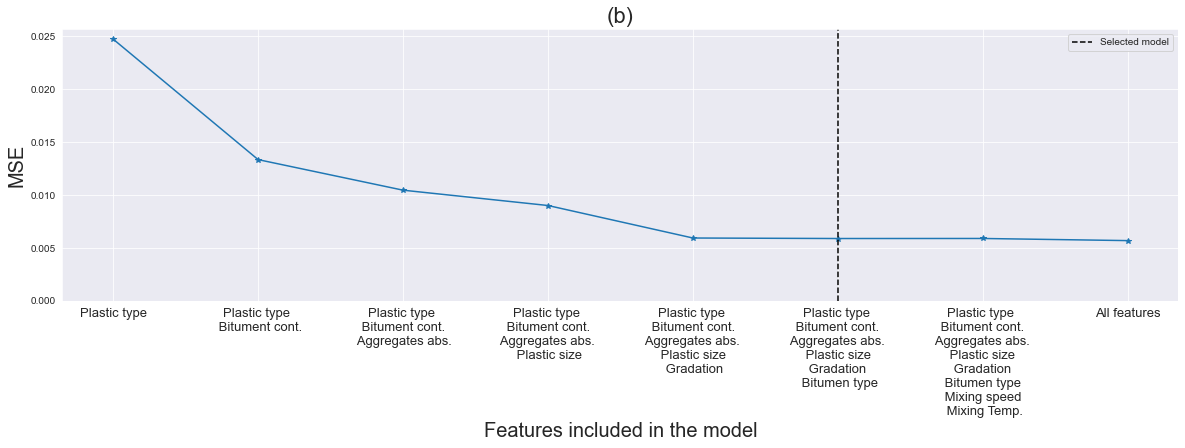

In [39]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
plt.ylim(ymin = 0)
plt.axvline(x='Plastic type \n Bitument cont. \n Aggregates abs. \n Plastic size \n Gradation \n Bitumen type', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
plt.ylabel('MSE', fontsize = 20)
plt.xlabel('Features included in the model', fontsize = 20)
plt.xticks(fontsize= 13)
plt.title('(b)', fontsize=22)
plt.legend()
plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [ ]:
X_train =  X_train[['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        ]]
X_test = X_test [['New Plastic Type_Nylon','New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PU', 'New Plastic Type_PVC','New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Bitumen content in the sample',
       'Aggregate absorption (%)',
       'Plastic particle size (mm)',
       '0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
       'Consolidated bitumen penetration grade_50/70','Consolidated bitumen penetration grade_70/100',
        ]]

### 6.3 Final model evaluation on test set

In [ ]:
def modelEvaluation (model, Title):
    min = dfMSCleanedImputed['MS of the sample (kN)'].min()
    max = dfMSCleanedImputed['MS of the sample (kN)'].max()
    #Model Fitting
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    #Model Evaluation
    r2_test = r2_score(y_test, predictions_test)
    mse_test = mean_squared_error(y_test, predictions_test)
    rmse_test_unscaled = (math.sqrt(mse_test)*(max-min))+min
    plt.figure(figsize=(7,7))
    #Model Plotting
    plt.scatter(y_test, predictions_test, c='crimson')
    plt.plot([(1,1), (0,0)], [(1,1), (0,0)], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.xlim (0,1)
    plt.ylim (0,1)
    plt.ylabel('Predictions - ' + Title, fontsize=18)
    plt.annotate('R2 = '+str(round(r2_test,3)), xy = (0.6,0.3), fontweight = 'bold', fontsize = 'xx-large')
    plt.annotate('RMSE = '+str(round(rmse_test_unscaled,3)), xy = (0.6,0.25), fontweight = 'bold', fontsize = 'xx-large')
    plt.show()
    return predictions_test

In [ ]:
XGModel = XGBRegressor(random_state = 123)
prediction_XGModel = modelEvaluation(XGModel, 'XGModel')

In [ ]:
XGModel.get_params

In [ ]:
extraTreeModel = ExtraTreesRegressor(n_estimators=400, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=90, random_state= 123, bootstrap=False)
prediction_ExtraTrees = modelEvaluation(extraTreeModel, 'Extra Trees model')

In [ ]:
RFModel = RandomForestRegressor(n_estimators=1000,min_samples_split=5, min_samples_leaf=1, max_features='auto', max_depth=None, random_state= 123, bootstrap=True)
prediction_RandomForest = modelEvaluation(RFModel, 'Random Forest Model')

### Outliers inspection

In [ ]:
XGModel = XGBRegressor(random_state = 123)
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
df = pd.DataFrame(data=[predictions_test,y_test], index=['prediction', 'y_test']).T
df = df.sort_values(by='y_test')

In [ ]:
min = dfMSCleanedImputed['MS of the sample (kN)'].min()
max = dfMSCleanedImputed['MS of the sample (kN)'].max()
df['prediction_uns'] = (df['prediction']*(max-min))+min
df['y_test_uns'] = (df['y_test']*(max-min))+min

## 6.3 ANOVA Analysis

In [ ]:
df_predictions = y_test.to_frame(name='real_Y')
df_predictions['XGModel_predictions'] = prediction_XGModel
df_predictions['ExtraTrees_predictions'] = prediction_ExtraTrees
df_predictions['RandomForest_predictions'] = prediction_RandomForest
def normalityTest (model, data, alpha=0.05):
    k2, p = stats.normaltest(data)
    if p > alpha:
        print ('The ' + model + ' is probably Gaussian. p-value = ' + str(p))
    else:
        print ('The ' + model +' is not probably Gaussian. p-value = '+ str(p))

### Normality evaluation

In [ ]:
normalityTest(data = df_predictions['real_Y'], model = 'real values')
normalityTest(data = df_predictions['RandomForest_predictions'], model = 'Random Forest')
normalityTest(data = df_predictions['XGModel_predictions'], model = 'XG model')
normalityTest(data = df_predictions['ExtraTrees_predictions'], model = 'Extra trees')

### Variance homogeneity (Bartlett's test) 

In [ ]:
stal, p = stats.bartlett(df_predictions['real_Y'], df_predictions['RandomForest_predictions'], df_predictions['XGModel_predictions'], df_predictions['ExtraTrees_predictions'])
if p > 0.05:
    print('There is not sufficient evidence to say that the variance of the real values and the predictors are differents. The p-value is ' + str(p))
else:
    print('There is non-homogeneity in the variance. The p-value is ' + str(p))

In [ ]:
stats.f_oneway(df_predictions['real_Y'],
               df_predictions['RandomForest_predictions'],
               df_predictions['XGModel_predictions'],
               df_predictions['ExtraTrees_predictions'])

There is not statistical differences between the predicted values by the three models and the observed values

## 6.4 Goodness of fit Analysis

In [ ]:
def evaluateGOF (y_real, model_predictions, Model, alpha = 0.05):
    stat, p_value  = stats.ks_2samp(y_real, model_predictions, alternative='two-sided')
    if p_value > 0.05:
        print ('The real values and the predictions of '+Model+' come from the same distribution according to the Kolmogorov-Smirnov test. The p-value is '+str(p_value))
    else:
        print ('The real values and the predictions of '+Model+'DO NOT come from the same distribution. The p-value is '+str(p_value))

In [ ]:
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['RandomForest_predictions'], Model = 'Random Forest')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['XGModel_predictions'], Model = 'Boosted Tree')
evaluateGOF(y_real=df_predictions['real_Y'], model_predictions=df_predictions['ExtraTrees_predictions'], Model = 'Extra treees')

In [ ]:
df_predictions.to_clipboard()

# 🚨 Marshall Stability Effect and Shap values

In [6]:
dfMSEffect = returnDf('MSEffect')

In [7]:
dfMSEffectNoOutliers = eliminateOutliers(dfMSEffect, 'Effect(%)')

Initial dataframe size: (263, 37)
Final dataframe size: (242, 37)


In [8]:
dfMSEffectNoOutliers['Virgin Bitumen Penetration'] = pd.to_numeric(dfMSEffectNoOutliers['Virgin Bitumen Penetration'])

<ipython-input-8-3484696dfbd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMSEffectNoOutliers['Virgin Bitumen Penetration'] = pd.to_numeric(dfMSEffectNoOutliers['Virgin Bitumen Penetration'])


In [9]:
dfMSEffectNoOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 1 to 402
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              242 non-null    object 
 1   Global ID                               242 non-null    object 
 2   Modified asphalt Mix?                   242 non-null    object 
 3   Agreggate Type                          154 non-null    object 
 4   Aggregate absorption (%)                142 non-null    float64
 5   Apparent specific gravity               44 non-null     float64
 6   0.075                                   184 non-null    float64
 7   0.3                                     217 non-null    float64
 8   0.6                                     203 non-null    float64
 9   2.36                                    209 non-null    float64
 10  4.75                                    217 non-null    float6

## 🛀 Data Preprocessing

In [10]:
#Categorical Variables
dfMSEffectNoOutliers = dfMSEffectNoOutliers.drop(['Article ID', 
                                    'Global ID',
                                    'Modified asphalt Mix?',
                                    'Agreggate Type', 
                                    'Apparent specific gravity', 
                                    'Filler used', 
                                    'Bitumen Type Penetration Grade', 
                                    'Property', 
                                    'Units', 
                                    'Plastic Size',
                                    'Consolidated bitumen penetration grade' ], axis = 1)
dfMSEffectNoOutliers = dfMSEffectNoOutliers.dropna(subset=['New Plastic Type'])
dfMSEffectNoOutliers = pd.get_dummies(dfMSEffectNoOutliers, columns=['New Plastic Type'], drop_first=True)
dfMSEffectNoOutliers = pd.get_dummies(dfMSEffectNoOutliers, drop_first=True)

In [11]:
dfMSEffectNoOutliers

,Aggregate absorption (%),0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Virgin Bitumen Penetration,Plastic particle size (mm),Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Plastic Addition by bitumen weight (%),Bitumen content in the sample,MS Control kN),MS of the sample (kN),Effect(%),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Mixing Process_Wet,Aggregates replacement ?_Yes,Bitumen replacement?_Yes,Filler replacement_Yes
MSEffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.40,2.99,5.30,21.8,35.75,38.90,57.35,73.04,97.23,40.0,2.50,0.0,0.0,0.0,15.000000,5.50,12.954,15.0822,-0.164289,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0.40,2.99,5.30,21.8,35.75,38.90,57.35,73.04,97.23,40.0,2.50,0.0,0.0,0.0,8.000000,5.50,12.954,15.3566,-0.185472,0,0,1,0,0,0,0,0,1,0,0,0,0
6,0.50,9.00,13.00,14.0,20.00,24.00,47.00,90.00,100.00,40.0,2.50,0.0,0.0,0.0,90.497738,6.63,10.250,13.9200,-0.358049,0,0,0,0,1,0,0,0,1,0,0,0,0
7,0.50,9.00,13.00,14.0,20.00,24.00,47.00,90.00,100.00,40.0,2.50,0.0,0.0,0.0,105.580694,6.63,10.250,14.1200,-0.377561,0,0,0,0,1,0,0,0,1,0,0,0,0
8,0.50,9.00,13.00,14.0,20.00,24.00,47.00,90.00,100.00,40.0,2.50,0.0,0.0,0.0,120.663650,6.63,10.250,14.8400,-0.447805,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.13,5.28,14.47,20.8,35.37,46.15,60.51,66.84,83.32,63.0,4.75,0.0,0.0,0.0,10.000000,5.00,12.970,11.6100,0.104857,1,0,0,0,0,0,0,0,1,0,0,0,0
393,0.13,5.28,14.47,20.8,35.37,46.15,60.51,66.84,83.32,63.0,4.75,0.0,0.0,0.0,22.222222,4.50,11.660,12.7400,-0.092624,1,0,0,0,0,0,0,0,1,0,0,0,0
394,0.13,5.28,14.47,20.8,35.37,46.15,60.51,66.84,83.32,63.0,4.75,0.0,0.0,0.0,20.000000,5.00,12.970,11.5600,0.108712,1,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
# Split X and Y
X = dfMSEffectNoOutliers[dfMSEffectNoOutliers.columns.difference(['Effect(%)','MS Control kN)', 'MS of the sample (kN)'])]
y = dfMSEffectNoOutliers[['Effect(%)']]
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Filler replacement_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic Addition by bitumen weight (%),Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
MSEffect ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.99,5.3,21.8,35.75,38.9,57.35,73.04,97.23,0.4,0,5.50,0,0,0,0.0,0.0,0.0,0,0,1,0,0,0,15.000000,2.5,0,0,1,40.0
2,2.99,5.3,21.8,35.75,38.9,57.35,73.04,97.23,0.4,0,5.50,0,0,0,0.0,0.0,0.0,0,0,1,0,0,0,8.000000,2.5,0,0,1,40.0
6,9.00,13.0,14.0,20.00,24.0,47.00,90.00,100.00,0.5,0,6.63,0,0,0,0.0,0.0,0.0,0,0,0,0,1,0,90.497738,2.5,0,0,1,40.0
7,9.00,13.0,14.0,20.00,24.0,47.00,90.00,100.00,0.5,0,6.63,0,0,0,0.0,0.0,0.0,0,0,0,0,1,0,105.580694,2.5,0,0,1,40.0
8,9.00,13.0,14.0,20.00,24.0,47.00,90.00,100.00,0.5,0,6.63,0,0,0,0.0,0.0,0.0,0,0,0,0,1,0,120.663650,2.5,0,0,1,40.0


In [13]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state = 123), max_iter=50,random_state = 123)
n = imputer.fit_transform(X)
X_Imputed = pd.DataFrame(n, columns = list(X.columns))
print ('There is '+ 
str(sum(n < 0 for n in X_Imputed.loc[:,X_Imputed.columns].values.flatten()))+
' negative values in the new DataFrame')

There is 0 negative values in the new DataFrame


In [14]:
X_Imputed['New Plastic Type_PE'] = X_Imputed['New Plastic Type_PE'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PET'] = X_Imputed['New Plastic Type_PET'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PP'] = X_Imputed['New Plastic Type_PP'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_PU'] = X_Imputed['New Plastic Type_PU'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_Plastic Mix'] = X_Imputed['New Plastic Type_Plastic Mix'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed['New Plastic Type_e-waste'] = X_Imputed['New Plastic Type_e-waste'] * X_Imputed['Plastic Addition by bitumen weight (%)']
X_Imputed = X_Imputed.drop(['Plastic Addition by bitumen weight (%)' ], axis = 1)

In [15]:
# Scaling
 #Feature Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_Imputed), columns = list(X_Imputed))
X.head()

,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Aggregate absorption (%),Aggregates replacement ?_Yes,Bitumen content in the sample,Bitumen replacement?_Yes,Filler replacement_Yes,Mixing Process_Wet,Mixing Temperature,Mixing Time (hours),Mixing speed (RPM),New Plastic Type_PE,New Plastic Type_PET,New Plastic Type_PP,New Plastic Type_PU,New Plastic Type_Plastic Mix,New Plastic Type_e-waste,Plastic particle size (mm),Plastic pretreatment_Plastic Melted,Plastic shape_Pellets,Plastic shape_Shredded,Virgin Bitumen Penetration
0,0.025740,0.000000,0.432432,0.420448,0.313684,0.21473,0.186972,0.832934,0.092784,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.000000,0.0,0.046185,0.0,0.0,1.0,0.0
1,0.025740,0.000000,0.432432,0.420448,0.313684,0.21473,0.186972,0.832934,0.092784,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.000000,0.0,0.046185,0.0,0.0,1.0,0.0
2,0.219112,0.251305,0.168919,0.000000,0.000000,0.00000,0.698432,0.998802,0.127148,0.0,0.876667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.0,0.046185,0.0,0.0,1.0,0.0
3,0.219112,0.251305,0.168919,0.000000,0.000000,0.00000,0.698432,0.998802,0.127148,0.0,0.876667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.583333,0.0,0.046185,0.0,0.0,1.0,0.0
4,0.219112,0.251305,0.168919,0.000000,0.000000,0.00000,0.698432,0.998802,0.127148,0.0,0.876667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.046185,0.0,0.0,1.0,0.0


## 🧠Model Training

In [16]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 123)

In [23]:
scores = cross_validate(XGBRegressor(random_state=123, n_estimators=500), X, y, cv=cv,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
np.average(scores['test_r2'])

0.599179903219964

## 🔪SHAP Values

In [17]:
import shap

In [19]:
model = XGBRegressor().fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


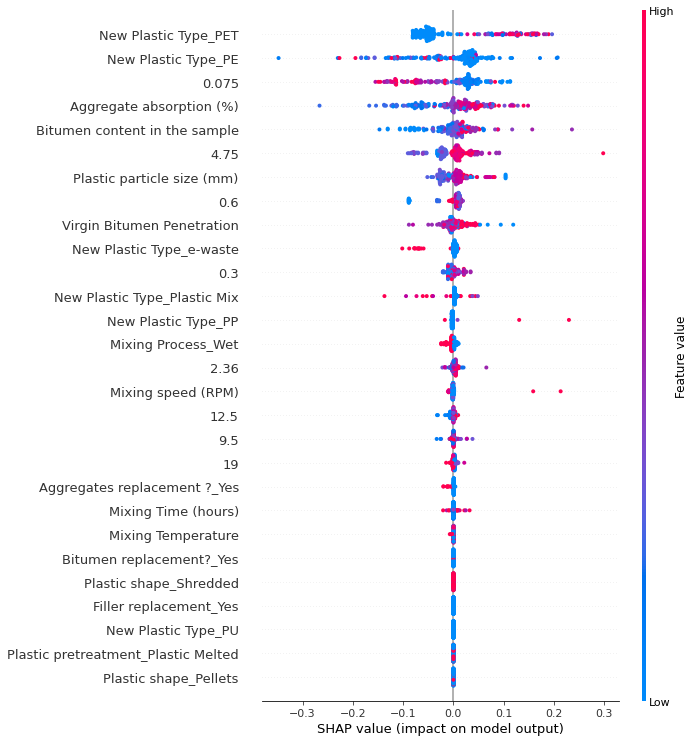

In [20]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=28)

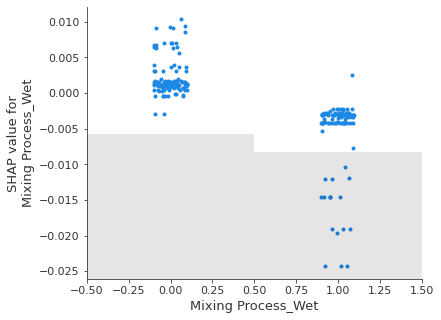

In [21]:
shap.plots.scatter(shap_values[:,'Mixing Process_Wet'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


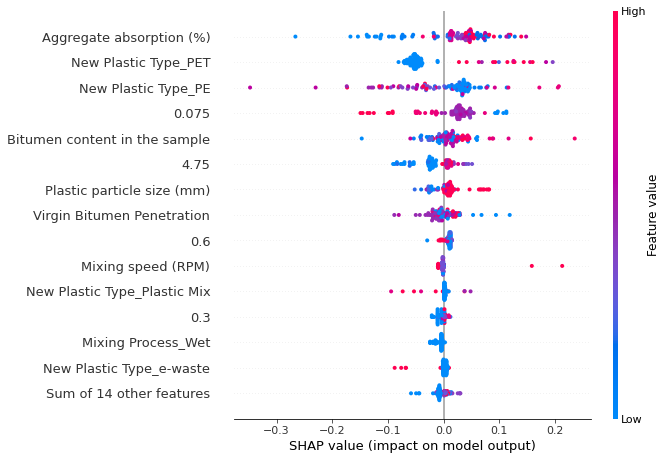

In [24]:
shap_values_wet = explainer(X[X['Mixing Process_Wet'] == 1])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_wet, max_display=15)

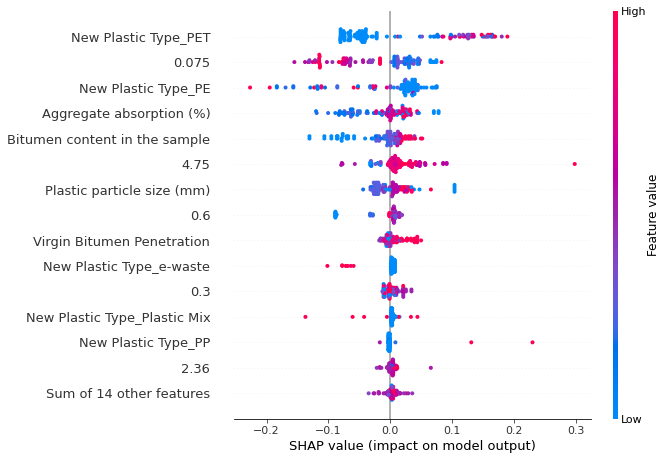

In [25]:
shap_values_dry = explainer(X[X['Mixing Process_Dry'] == 0])
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_dry, max_display=15)